<a href="https://colab.research.google.com/github/simoneseverini/automated-discovery-site/blob/main/ABM_Intelligence_Phase_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intelligence Crisis vs. Boom: An Agent-Based Phase Space Model

**Objective:** Build a single ABM that can produce *both* the Citrini "2028 Global Intelligence Crisis" scenario *and* the Bloch "2028 Global Intelligence Boom" scenario as emergent outcomes, depending on a small number of empirically measurable parameters.

The real deliverable is the **phase boundary** between them: the critical surface in parameter space where the economy tips from boom to crisis.

## Model Architecture

**Agents:** 2,000 households (employed/unemployed, white-collar/blue-collar/entrepreneur) with income, savings, housing, mortgages, equity ownership. 3 firm sectors: Digital/SaaS, Physical, New/Emergent. Aggregate banking. Government with UBI.

**Key mechanisms:**
1. **AI displacement spiral** (Citrini): AI improves → firms automate → layoffs → less spending → more automation
2. **Entrepreneurship engine** (Bloch): Displaced workers start businesses, AI lowers barriers
3. **Deflation dynamics**: Digital prices collapse; purchasing power rises *if* spending redirects to new goods
4. **Financial contagion**: SaaS defaults → PE/bank losses → credit tightening → mortgage stress
5. **Housing market**: Prices respond to income; mortgage defaults cascade

**Three critical parameters determine which scenario emerges:**

| Parameter | Crisis regime | Boom regime |
|---|---|---|
| `entrepreneurship_rate` | Low (< 0.05/month) | High (> 0.12/month) |
| `deflation_spending_rate` | Low (savings hoarding) | High (spend on new goods) |
| `financial_contagion_strength` | High (fragile daisy chain) | Low (diversified) |


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from dataclasses import dataclass
from typing import Dict
from copy import deepcopy
import warnings, time
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.facecolor': '#0d1117', 'axes.facecolor': '#0d1117',
    'axes.edgecolor': '#30363d', 'axes.labelcolor': '#c9d1d9',
    'text.color': '#c9d1d9', 'xtick.color': '#8b949e',
    'ytick.color': '#8b949e', 'grid.color': '#21262d',
    'figure.dpi': 110, 'font.size': 11,
})
CR = '#f85149'; BM = '#3fb950'; NT = '#58a6ff'; WR = '#d29922'
print("Environment ready")


Environment ready


## Model Parameters
The three **phase-critical** parameters are highlighted.

In [2]:
@dataclass
class Params:
    # Scale
    n_households: int = 2000
    T: int = 120  # months (10 years)
    seed: int = 42

    # AI dynamics
    ai_growth_rate: float = 0.03       # monthly (~43%/yr)
    base_ai_cost: float = 120.0
    automation_lag: float = 3.0        # AI must be Nx cheaper than wage

    # Labor
    white_collar_frac: float = 0.50
    wc_wage: float = 150.0             # scaled monthly
    bc_wage: float = 75.0
    wage_cv: float = 0.25
    downshift_penalty: float = 0.45

    # ━━━ PHASE-CRITICAL 1 ━━━
    entrepreneurship_rate: float = 0.08
    new_firm_cost: float = 80.0
    new_firm_survival: float = 0.97
    new_firm_emp: float = 3.0
    new_firm_rev_per_emp: float = 10.0

    # ━━━ PHASE-CRITICAL 2 ━━━
    deflation_spending_rate: float = 0.50

    # Consumption
    mpc_income: float = 0.75
    mpc_savings: float = 0.02
    subsistence: float = 30.0

    # Pricing
    digital_frac: float = 0.40
    physical_floor: float = 55.0
    digital_floor: float = 1.0
    init_price: float = 100.0
    digital_defl_speed: float = 0.04
    physical_defl_speed: float = 0.005
    saas_erosion_start: float = 4.0
    saas_erosion_rate: float = 0.015

    # Housing
    home_income_mult: float = 5.0
    init_ltv: float = 0.78
    mortgage_rate: float = 0.065
    mortgage_term: int = 360
    default_income_ratio: float = 0.35
    default_savings_buffer: int = 4
    home_price_speed: float = 0.02
    foreclosure_discount: float = 0.20

    # Finance
    pe_frac: float = 0.30
    pe_leverage: float = 3.5
    bank_init_cap: float = 0.10
    # ━━━ PHASE-CRITICAL 3 ━━━
    financial_contagion: float = 0.50
    bank_cap_floor: float = 0.04
    corp_recovery: float = 0.40
    mort_recovery: float = 0.55

    # Equity
    div_payout: float = 0.25
    equity_pareto: float = 1.8

    # Government
    income_tax: float = 0.22
    corp_tax: float = 0.21
    ubi_trigger: float = 0.08
    ubi_amount: float = 55.0
    fiscal_lag: int = 6


def citrini_params():
    return Params(
        entrepreneurship_rate=0.03, deflation_spending_rate=0.20,
        financial_contagion=0.80, new_firm_survival=0.94,
        pe_leverage=4.0, fiscal_lag=9)

def bloch_params():
    return Params(
        entrepreneurship_rate=0.16, deflation_spending_rate=0.75,
        financial_contagion=0.20, new_firm_survival=0.98,
        pe_leverage=2.5, fiscal_lag=4)

print("Parameter classes defined")
print(f"  Defaults: ent={Params().entrepreneurship_rate}, "
      f"defl={Params().deflation_spending_rate}, cntg={Params().financial_contagion}")


Parameter classes defined
  Defaults: ent=0.08, defl=0.5, cntg=0.5


## Core Simulation Engine

Each tick (month): AI grows → firms automate → workers displaced/reemployed/entrepreneurship →
prices deflate → households consume → housing adjusts → financial contagion → government responds.


In [3]:
def run_simulation(params):
    # Unpack
    p = params
    rng = np.random.default_rng(p.seed)
    T, n_h = p.T, p.n_households

    # ── INIT HOUSEHOLDS ──
    is_wc = np.zeros(n_h, dtype=bool)
    is_wc[:int(n_h * p.white_collar_frac)] = True
    rng.shuffle(is_wc)

    h_base = np.where(is_wc,
        p.wc_wage * (1 + p.wage_cv * rng.standard_normal(n_h)),
        p.bc_wage * (1 + p.wage_cv * rng.standard_normal(n_h))).clip(20)
    h_inc = h_base.copy()
    h_sav = h_inc * rng.uniform(3, 15, n_h)
    h_emp = np.ones(n_h, dtype=bool)
    h_ent = np.zeros(n_h, dtype=bool)
    h_unemp_mo = np.zeros(n_h, dtype=int)

    # Housing
    h_hval = h_base * p.home_income_mult * rng.uniform(0.8, 1.2, n_h)
    h_mbal = h_hval * p.init_ltv
    mr = p.mortgage_rate / 12
    h_mpmt = h_mbal * mr / (1 - (1+mr)**(-p.mortgage_term))
    h_def = np.zeros(n_h, dtype=bool)

    # Equity shares (Pareto, correlated with income)
    raw_eq = rng.pareto(p.equity_pareto, n_h)
    rank = np.argsort(np.argsort(h_base))
    h_eqsh = np.zeros(n_h)
    h_eqsh[np.argsort(rank)] = np.sort(raw_eq)
    h_eqsh /= h_eqsh.sum()

    # ── INIT FIRMS (aggregate by sector) ──
    n_dig = int(100 * p.digital_frac)
    n_phy = 100 - n_dig
    n_new = 0
    dig_emp = n_dig * 15.0
    phy_emp = n_phy * 20.0
    new_emp = 0.0
    dig_rev = dig_emp * 12.0
    phy_rev = phy_emp * 8.0
    new_rev = 0.0
    dig_price = p.init_price
    phy_price = p.init_price
    new_price = p.init_price * 0.7
    dig_auto = 0.0
    phy_auto = 0.0

    n_pe = int(n_dig * p.pe_frac)
    pe_debt = n_pe * 15 * 12 * p.pe_leverage
    pe_def_cum = 0.0
    tot_corp_debt = dig_rev * 3 + phy_rev * 2 + pe_debt

    # ── INIT BANKS ──
    tot_mort = h_mbal.sum()
    bank_cap = (tot_mort + tot_corp_debt) * p.bank_init_cap
    credit_tight = 0.0

    # ── GOVERNMENT ──
    ubi_on = False
    ubi_wait = 0
    cum_deficit = 0.0

    # ── STORAGE ──
    keys = ['unemp','wc_unemp','gdp_idx','med_inc','purch_pwr','consumption',
            'hpi','mort_def','firm_def','sp500','gini','n_firms','n_new','new_mo',
            'ai_cap','dig_px','phy_px','bank_cap_r','credit_tight','deficit_flow',
            'cum_deficit','velocity','labor_share','ubi_on','wc_med_inc',
            'dig_emp','phy_emp','new_emp_ts','avg_sav','ent_flow']
    ts = {k: np.zeros(T) for k in keys}

    init_gdp = h_inc.sum()
    init_med = np.median(h_inc)
    init_sp = dig_rev * 8 + phy_rev * 5
    init_wc_med = np.median(h_inc[is_wc])
    hpm = 1.0  # home price multiplier

    for t in range(T):
        # 1. AI
        ai = (1 + p.ai_growth_rate) ** t
        ai_cost = p.base_ai_cost / ai

        # 2. Automation
        wc_w = h_inc[is_wc & h_emp].mean() if (is_wc & h_emp).any() else p.wc_wage
        bc_w = h_inc[~is_wc & h_emp].mean() if (~is_wc & h_emp).any() else p.bc_wage

        if ai_cost < wc_w / p.automation_lag:
            dig_auto = min(0.95, dig_auto + 0.04 * (1 + credit_tight * 0.5))
        if ai_cost < bc_w / p.automation_lag:
            phy_auto = min(0.70, phy_auto + 0.01)

        dig_tgt = n_dig * 15.0 * (1 - dig_auto)
        phy_tgt = n_phy * 20.0 * (1 - phy_auto)
        layoffs = max(0, dig_emp - dig_tgt) + max(0, phy_emp - phy_tgt)
        dig_emp = max(dig_tgt, n_dig * 0.5)
        phy_emp = max(phy_tgt, n_phy * 2.0)

        # 3. Displacement
        n_disp = min(int(layoffs * n_h / max(1, n_dig*15 + n_phy*20)),
                     int(h_emp.sum() * 0.03))
        if n_disp > 0:
            wc_pool = np.where(is_wc & h_emp & ~h_ent)[0]
            bc_pool = np.where(~is_wc & h_emp & ~h_ent)[0]
            n_wc = min(int(n_disp * 0.7), len(wc_pool))
            n_bc = min(n_disp - n_wc, len(bc_pool))
            if n_wc > 0:
                idx = rng.choice(wc_pool, n_wc, replace=False)
                h_emp[idx] = False; h_unemp_mo[idx] = 0
            if n_bc > 0:
                idx = rng.choice(bc_pool, n_bc, replace=False)
                h_emp[idx] = False; h_unemp_mo[idx] = 0

        h_unemp_mo[~h_emp & ~h_ent] += 1

        # 4. Entrepreneurship & reemployment
        unemp_mask = ~h_emp & ~h_ent & ~h_def
        n_unemp = unemp_mask.sum()
        new_ent_ct = 0

        if n_unemp > 0:
            ui = np.where(unemp_mask)[0]
            scost = p.new_firm_cost / (1 + 0.5 * np.log1p(ai))
            can_aff = h_sav[ui] > scost
            eff_r = min(0.30, p.entrepreneurship_rate * (1 + 0.3 * np.log1p(ai)))
            rolls = rng.random(n_unemp)
            becomes = (rolls < eff_r) & can_aff
            ei = ui[becomes]
            if len(ei) > 0:
                h_ent[ei] = True; h_emp[ei] = True
                h_sav[ei] -= scost
                h_inc[ei] = p.new_firm_rev_per_emp * p.new_firm_emp * 0.3
                new_ent_ct = len(ei)
                n_new += new_ent_ct
                new_emp += new_ent_ct * p.new_firm_emp
                new_rev += new_ent_ct * p.new_firm_emp * p.new_firm_rev_per_emp

            # Reemployment for remaining unemployed
            still = ui[~becomes]
            if len(still) > 0:
                rp = 0.08 * np.exp(-0.1 * h_unemp_mo[still])
                rehire = still[rng.random(len(still)) < rp]
                if len(rehire) > 0:
                    h_emp[rehire] = True
                    h_inc[rehire] = np.where(is_wc[rehire],
                        p.bc_wage * p.downshift_penalty * rng.uniform(0.8,1.2,len(rehire)),
                        h_base[rehire] * 0.85)
                    h_unemp_mo[rehire] = 0

        # New firm attrition
        if n_new > 0:
            dying = rng.binomial(max(0, int(n_new)), float(np.clip(1 - p.new_firm_survival, 0, 1)))
            if dying > 0:
                n_new = max(0, n_new - dying)
                lost = dying * p.new_firm_emp
                new_emp = max(0, new_emp - lost)
                new_rev = max(0, new_rev - lost * p.new_firm_rev_per_emp)
                eidx = np.where(h_ent)[0]
                if len(eidx) > 0:
                    nf = min(dying, len(eidx))
                    failed = rng.choice(eidx, nf, replace=False)
                    h_ent[failed] = False; h_emp[failed] = False
                    h_unemp_mo[failed] = 0

        # Entrepreneur income growth
        if h_ent.any():
            h_inc[h_ent] *= (1 + 0.02 * min(ai/5, 1.0))
            h_inc[h_ent] = h_inc[h_ent].clip(max=p.wc_wage * 2)

        h_inc[~h_emp] = 0

        # 5. Pricing
        if ai > 2.0:
            dig_price = max(p.digital_floor,
                           dig_price * (1 - p.digital_defl_speed * min(ai/10, 1.0)))
        phy_price = max(p.physical_floor, phy_price * (1 - p.physical_defl_speed))
        if n_new > 0:
            new_price = max(40.0, new_price * 0.998)

        tot_f = max(1, n_dig + n_phy + n_new)
        px_idx = (n_dig*dig_price + n_phy*phy_price + n_new*new_price) / (tot_f * p.init_price)

        if ai > p.saas_erosion_start:
            er = p.saas_erosion_rate * (ai - p.saas_erosion_start) / 10
            dig_rev *= (1 - min(er, 0.05))
            dig_rev = max(dig_rev, n_dig * 2.0)

        # 6. Consumption
        urate = 1 - h_emp.sum() / n_h
        if urate > p.ubi_trigger and not ubi_on:
            ubi_wait += 1
            if ubi_wait >= p.fiscal_lag: ubi_on = True
        elif urate <= p.ubi_trigger * 0.7:
            ubi_on = False; ubi_wait = 0

        ubi_pmt = p.ubi_amount if ubi_on else 0.0
        profits = max(0, (dig_rev + phy_rev + new_rev) * 0.15)
        div_pool = profits * p.div_payout
        h_div = h_eqsh * div_pool
        h_gross = h_inc + ubi_pmt + h_div
        defl_sav = max(0, (1 - px_idx) * p.init_price * 0.5)

        h_cons = (h_gross * p.mpc_income +
                  h_sav.clip(0) * p.mpc_savings +
                  defl_sav * p.deflation_spending_rate).clip(min=p.subsistence)

        mort_mask = (h_mbal > 0) & ~h_def
        h_sav += h_gross - h_cons - h_mpmt * mort_mask
        h_sav = h_sav.clip(min=-h_hval * 0.1)
        tot_cons = h_cons.sum()

        # 7. Housing
        cur_agg_inc = h_inc[h_emp].sum()
        init_agg = h_base.sum()
        inc_ratio = cur_agg_inc / max(init_agg * 0.1, init_agg)
        hpm += (inc_ratio - hpm) * p.home_price_speed
        h_hval_cur = h_hval * hpm

        at_risk = (mort_mask &
                   (h_gross < h_mpmt * p.default_income_ratio) &
                   (h_sav < h_mpmt * p.default_savings_buffer))
        new_def = at_risk & (rng.random(n_h) < 0.15)
        h_def |= new_def

        if new_def.any():
            floss = (h_mbal[new_def] - h_hval_cur[new_def]*(1-p.foreclosure_discount)).clip(0).sum()
            h_mbal[new_def] = 0; h_mpmt[new_def] = 0
            h_hval[new_def] *= (1 - p.foreclosure_discount)
            hpm *= (1 - 0.001 * new_def.sum())
        else:
            floss = 0

        # 8. Financial contagion
        pe_dp = 0.0
        if ai > p.saas_erosion_start:
            rdecl = max(0, 1 - dig_rev / max(1, n_dig * 15 * 12))
            pe_dp = min(0.05, max(0, rdecl * 0.1 * (1 + credit_tight)))
        pe_this = rng.binomial(max(0, n_pe), float(np.clip(pe_dp, 0, 1)))
        pe_loss = pe_this * 15 * 12 * p.pe_leverage * (1 - p.corp_recovery)

        tot_bloss = floss * (1 - p.mort_recovery) + pe_loss * (1 - p.corp_recovery)
        bank_cap = max(0, bank_cap - tot_bloss)

        bank_assets = h_mbal[~h_def].sum() + max(0, pe_debt - pe_def_cum)
        bcr = bank_cap / max(bank_assets, 1)

        if bcr < p.bank_init_cap:
            stress = (p.bank_init_cap - bcr) / p.bank_init_cap
            credit_tight = min(1.0, stress * p.financial_contagion * 3)
        else:
            credit_tight = max(0, credit_tight - 0.02)
        pe_def_cum += pe_loss

        # 9. Revenue
        c2d = tot_cons * 0.3 * (1 - 0.5 * dig_auto)
        c2p = tot_cons * 0.5
        c2n = tot_cons * 0.2 * (n_new / max(1, n_new + 10))
        dig_rev = c2d * (dig_price / p.init_price)
        phy_rev = c2p * (phy_price / p.init_price)
        new_rev = c2n + n_new * p.new_firm_rev_per_emp * p.new_firm_emp

        # 10. Government
        tax_rev = h_inc[h_emp].sum() * p.income_tax + profits * p.corp_tax
        govt_out = ubi_pmt * n_h + n_h * 10
        dflow = govt_out - tax_rev
        cum_deficit += dflow

        # 11. Equity
        dm = max(2, 8 * (1 - dig_auto * 0.3))
        sp = (dig_rev*dm + phy_rev*5 + new_rev*max(3,10*(1-credit_tight))) * (1 - credit_tight*0.3)

        # 12. Record
        ne = h_emp.sum()
        ts['unemp'][t] = 1 - ne/n_h
        ts['wc_unemp'][t] = 1 - (is_wc & h_emp).sum() / max(1, is_wc.sum())
        ts['gdp_idx'][t] = tot_cons / max(1, init_gdp) * 100
        ts['med_inc'][t] = np.median(h_gross) / max(1, init_med) * 100
        ts['purch_pwr'][t] = np.median(h_gross) / max(0.01, px_idx) / init_med * 100
        ts['consumption'][t] = tot_cons
        ts['hpi'][t] = hpm * 100
        ts['mort_def'][t] = h_def.sum() / n_h * 100
        ts['sp500'][t] = sp / max(1, init_sp) * 100
        ts['n_firms'][t] = n_dig + n_phy + n_new
        ts['n_new'][t] = n_new
        ts['new_mo'][t] = new_ent_ct
        ts['ai_cap'][t] = ai
        ts['dig_px'][t] = dig_price / p.init_price * 100
        ts['phy_px'][t] = phy_price / p.init_price * 100
        ts['bank_cap_r'][t] = bcr * 100
        ts['credit_tight'][t] = credit_tight * 100
        ts['deficit_flow'][t] = dflow
        ts['cum_deficit'][t] = cum_deficit
        ts['velocity'][t] = tot_cons / max(1, h_sav.sum()) * 12
        ts['labor_share'][t] = h_inc[h_emp].sum() / max(1, tot_cons + profits) * 100
        ts['ubi_on'][t] = float(ubi_on)
        ts['wc_med_inc'][t] = np.median(h_gross[is_wc]) / max(1, init_wc_med) * 100 if is_wc.any() else 0
        ts['dig_emp'][t] = dig_emp
        ts['phy_emp'][t] = phy_emp
        ts['new_emp_ts'][t] = new_emp
        ts['avg_sav'][t] = h_sav.mean()
        ts['ent_flow'][t] = new_ent_ct

        sg = np.sort(h_gross)
        n = len(sg)
        ix = np.arange(1, n+1)
        ts['gini'][t] = (2*np.sum(ix*sg)/(n*np.sum(sg)) - (n+1)/n) if sg.sum()>0 else 0

    return ts

print("Simulation engine defined")


Simulation engine defined


## Visualization Functions

In [4]:
def plot_scenario(ts, title, params):
    mo = np.arange(params.T)
    yr = 2026 + mo / 12
    fig = plt.figure(figsize=(20, 24))
    gs = gridspec.GridSpec(5, 3, hspace=0.35, wspace=0.3,
                          left=0.06, right=0.97, top=0.95, bottom=0.03)

    def ax(r, c, t):
        a = fig.add_subplot(gs[r, c]); a.set_title(t, fontsize=11, fontweight='bold', pad=8)
        a.grid(True, alpha=0.15); return a

    a=ax(0,0,'Unemployment Rate')
    a.plot(yr, ts['unemp']*100, color=CR, lw=2, label='Total')
    a.plot(yr, ts['wc_unemp']*100, color=WR, lw=1.5, ls='--', label='White-collar')
    a.axhline(8, color='#8b949e', ls=':', alpha=0.5); a.set_ylabel('%'); a.legend(fontsize=8)

    a=ax(0,1,'GDP Index'); a.plot(yr, ts['gdp_idx'], color=NT, lw=2)
    a.axhline(100, color='#8b949e', ls=':', alpha=0.5); a.set_ylabel('Index')

    a=ax(0,2,'S&P 500 Proxy')
    c = BM if ts['sp500'][-1]>100 else CR
    a.plot(yr, ts['sp500'], color=c, lw=2); a.axhline(100, color='#8b949e', ls=':', alpha=0.5)

    a=ax(1,0,'Real Purchasing Power')
    c = BM if ts['purch_pwr'][-1]>100 else CR
    a.plot(yr, ts['purch_pwr'], color=c, lw=2); a.axhline(100, color='#8b949e', ls=':',alpha=0.5)

    a=ax(1,1,'Gini Coefficient'); a.plot(yr, ts['gini'], color=WR, lw=2)
    a=ax(1,2,'Labor Share'); a.plot(yr, ts['labor_share'], color=NT, lw=2); a.set_ylabel('%')

    a=ax(2,0,'Price Indices')
    a.plot(yr, ts['dig_px'], color='#bc8cff', lw=2, label='Digital')
    a.plot(yr, ts['phy_px'], color=WR, lw=2, label='Physical')
    a.legend(fontsize=8); a.set_ylabel('Index')

    a=ax(2,1,'AI Capability (log)'); a.semilogy(yr, ts['ai_cap'], color='#bc8cff', lw=2)

    a=ax(2,2,'Firm Landscape')
    a.stackplot(yr,
        [np.full(params.T, int(100*params.digital_frac))],
        [np.full(params.T, 100-int(100*params.digital_frac))],
        [ts['n_new']],
        labels=['Digital','Physical','New/Startup'],
        colors=['#bc8cff', WR, BM], alpha=0.7)
    a.legend(fontsize=8, loc='upper left'); a.set_ylabel('Firms')

    a=ax(3,0,'Housing'); a.plot(yr, ts['hpi'], color=NT, lw=2, label='Price Idx')
    a2=a.twinx(); a2.plot(yr, ts['mort_def'], color=CR, lw=1.5, ls='--', label='Default %')
    a2.set_ylabel('Default %', color=CR); a.legend(fontsize=8, loc='upper left')
    a2.legend(fontsize=8, loc='upper right')

    a=ax(3,1,'Bank Capital Ratio'); a.plot(yr, ts['bank_cap_r'], color=NT, lw=2)
    a.axhline(4, color=CR, ls=':', alpha=0.5); a.axhline(8, color=WR, ls=':', alpha=0.5)
    a.set_ylabel('%')

    a=ax(3,2,'Credit Tightening')
    a.fill_between(yr, ts['credit_tight'], color=CR, alpha=0.3)
    a.plot(yr, ts['credit_tight'], color=CR, lw=1.5); a.set_ylabel('%')

    a=ax(4,0,'Money Velocity'); a.plot(yr, ts['velocity'], color=NT, lw=2)
    a=ax(4,1,'New Business Formation'); a.bar(yr, ts['new_mo'], width=1/12, color=BM, alpha=0.7)

    a=ax(4,2,'Cumulative Deficit')
    a.plot(yr, ts['cum_deficit']/1000, color=CR, lw=2); a.set_ylabel('(thousands)')
    if ts['ubi_on'].any():
        ubi_m = ts['ubi_on'] > 0
        a.axvspan(yr[ubi_m][0], yr[ubi_m][-1], color=WR, alpha=0.08, label='UBI active')
        a.legend(fontsize=8)

    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    plt.show()


def plot_comparison(tc, tb, pc, pb):
    T = pc.T; yr = 2026 + np.arange(T)/12
    metrics = [
        ('unemp','Unemployment %',100), ('purch_pwr','Purchasing Power',1),
        ('sp500','S&P 500',1), ('n_new','New Firms',1),
        ('hpi','Home Price Idx',1), ('mort_def','Mortgage Defaults %',1),
        ('velocity','Money Velocity',1), ('gini','Gini',1),
        ('labor_share','Labor Share %',1)]
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle('CRISIS vs BOOM: Head-to-Head', fontsize=16, fontweight='bold', y=1.01)
    for i,(k,tl,m) in enumerate(metrics):
        a = axes[i//3, i%3]
        a.plot(yr, tc[k]*m, color=CR, lw=2, label='Crisis')
        a.plot(yr, tb[k]*m, color=BM, lw=2, label='Boom')
        a.set_title(tl, fontsize=10, fontweight='bold'); a.grid(True, alpha=0.15)
        if i==0: a.legend(fontsize=8)
    plt.tight_layout(); plt.show()

print("Visualization defined")


Visualization defined


## Run Both Scenarios
Citrini Crisis vs Bloch Boom, side by side.

In [5]:
print("Running Citrini Crisis...")
t0 = time.time()
pc = citrini_params()
tc = run_simulation(pc)
print(f"  {time.time()-t0:.1f}s | Unemp: {tc['unemp'][-1]*100:.1f}% | "
      f"S&P: {tc['sp500'][-1]:.0f} | Purch.Pwr: {tc['purch_pwr'][-1]:.0f} | "
      f"New firms: {tc['n_new'][-1]:.0f}")

print("Running Bloch Boom...")
t0 = time.time()
pb = bloch_params()
tb = run_simulation(pb)
print(f"  {time.time()-t0:.1f}s | Unemp: {tb['unemp'][-1]*100:.1f}% | "
      f"S&P: {tb['sp500'][-1]:.0f} | Purch.Pwr: {tb['purch_pwr'][-1]:.0f} | "
      f"New firms: {tb['n_new'][-1]:.0f}")


Running Citrini Crisis...
  0.2s | Unemp: 15.7% | S&P: 792 | Purch.Pwr: 194 | New firms: 295
Running Bloch Boom...
  0.2s | Unemp: 13.7% | S&P: 887 | Purch.Pwr: 164 | New firms: 797


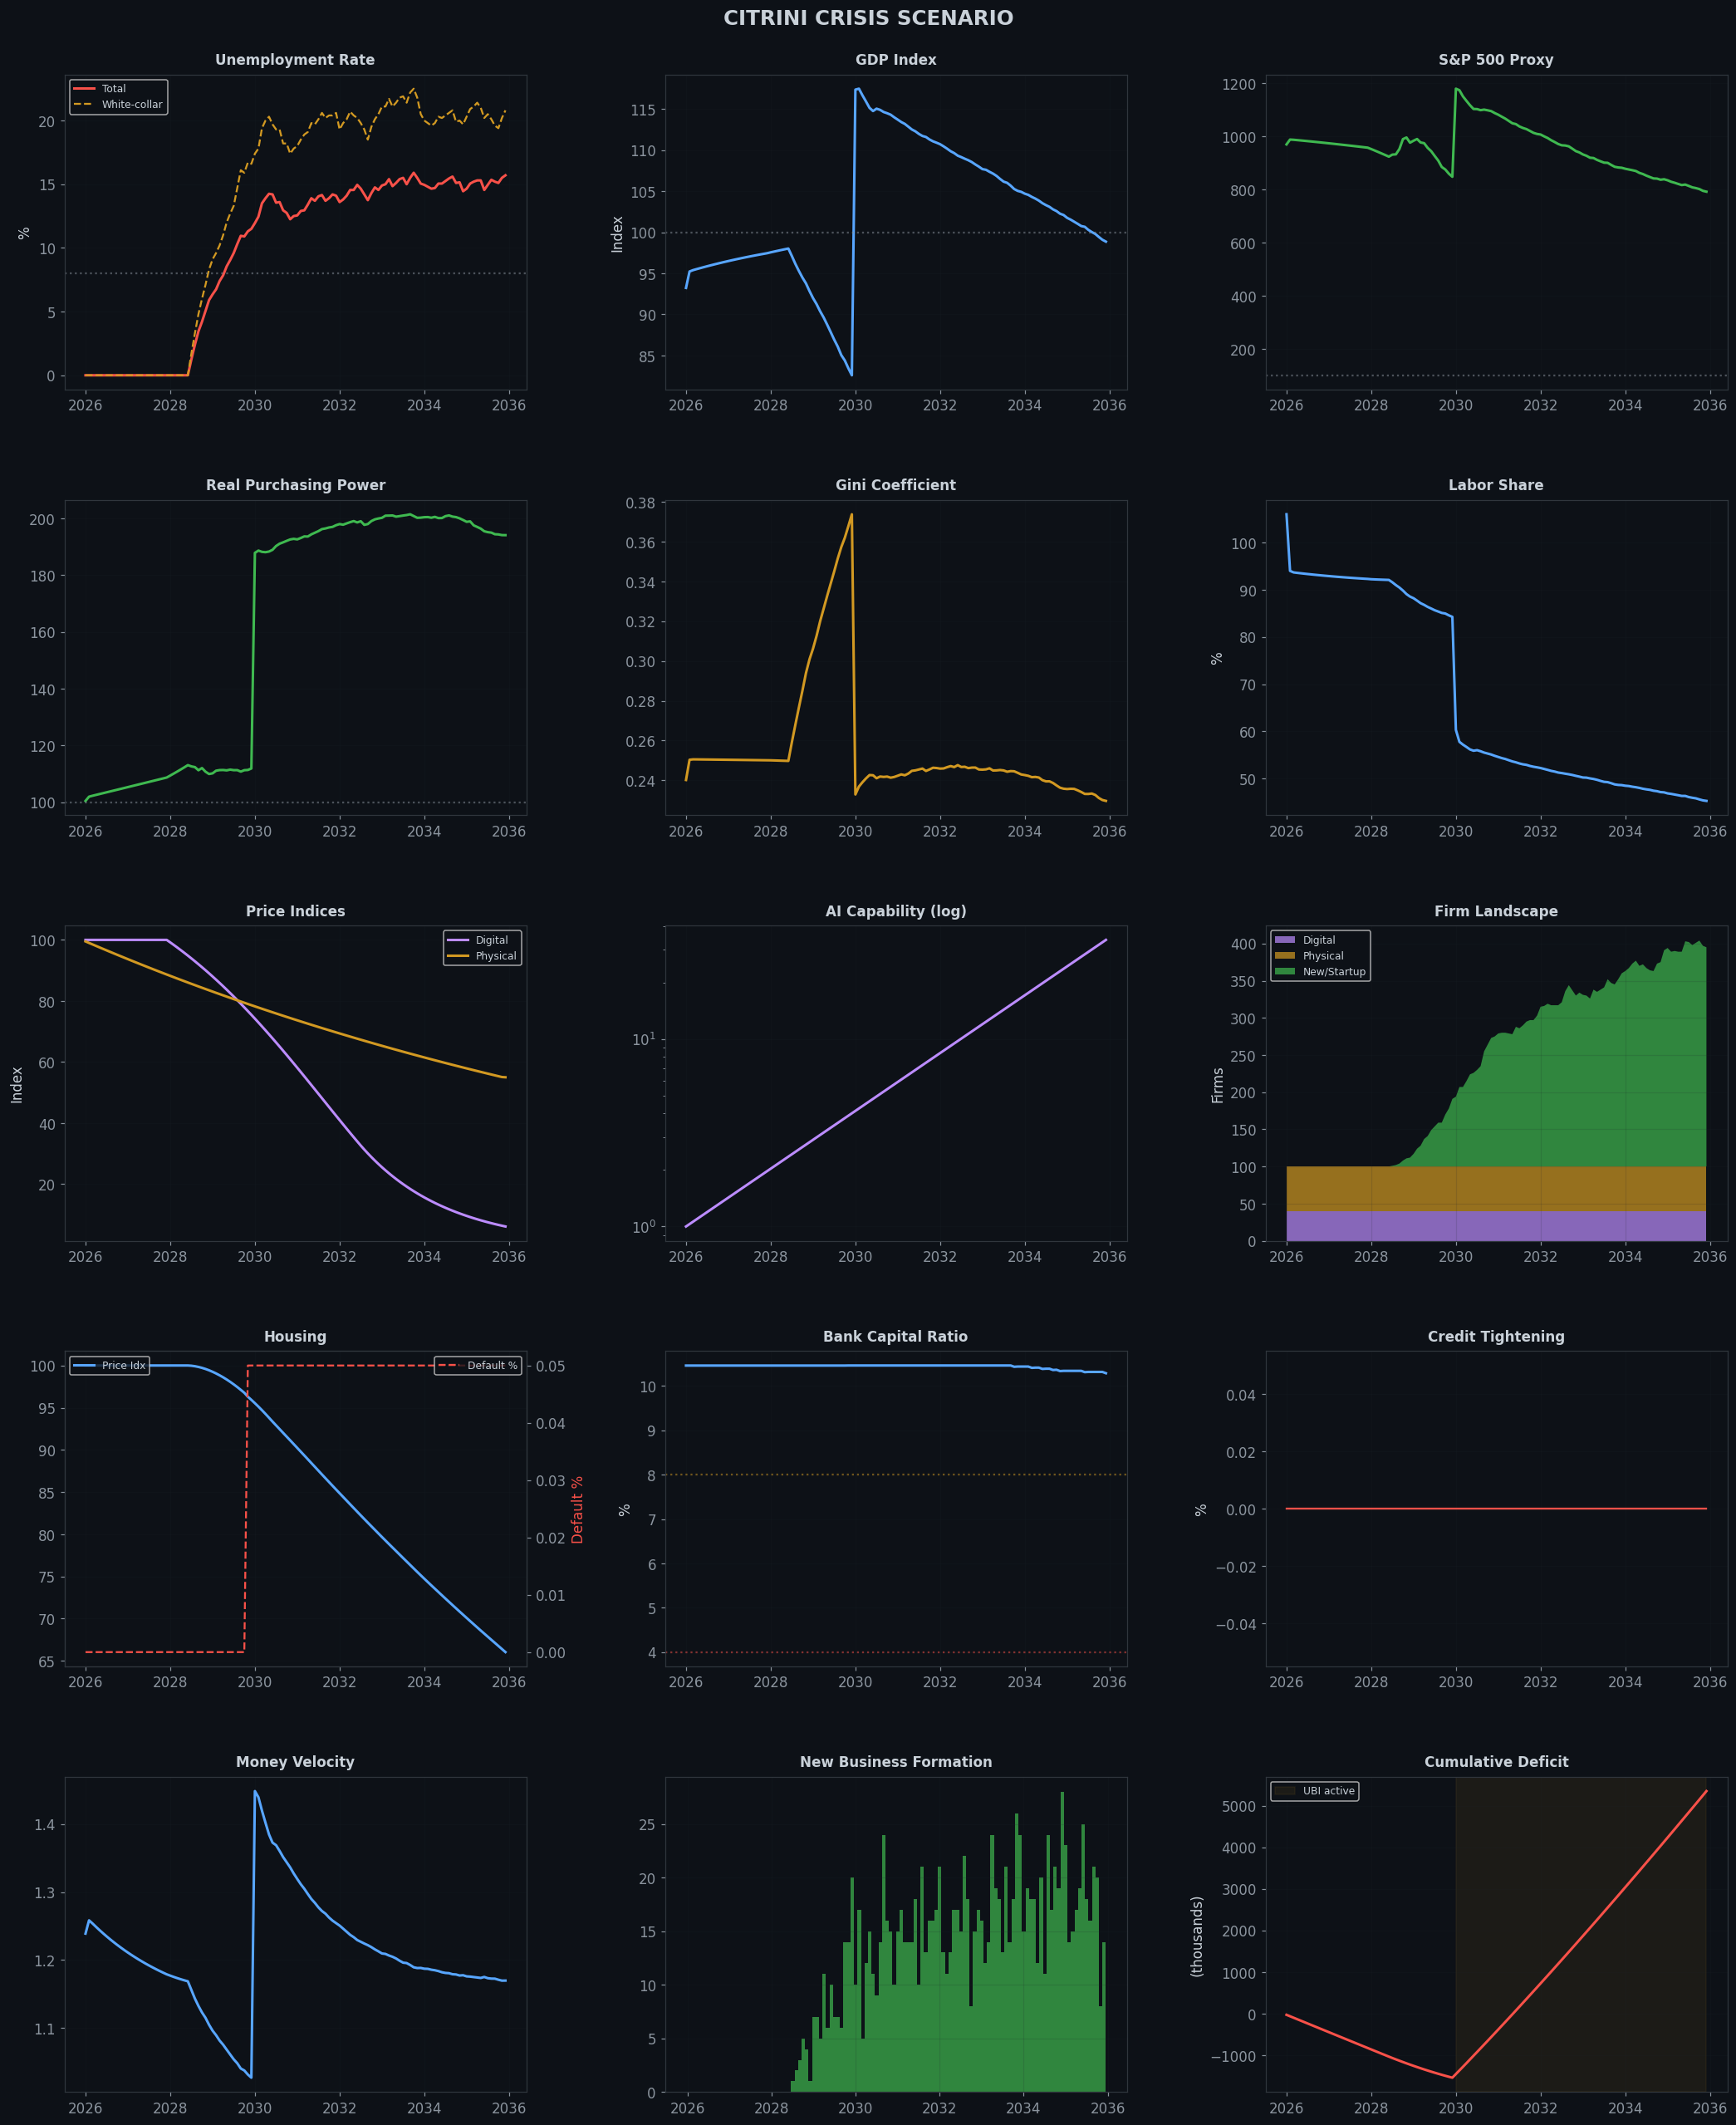

In [6]:
plot_scenario(tc, 'CITRINI CRISIS SCENARIO', pc)

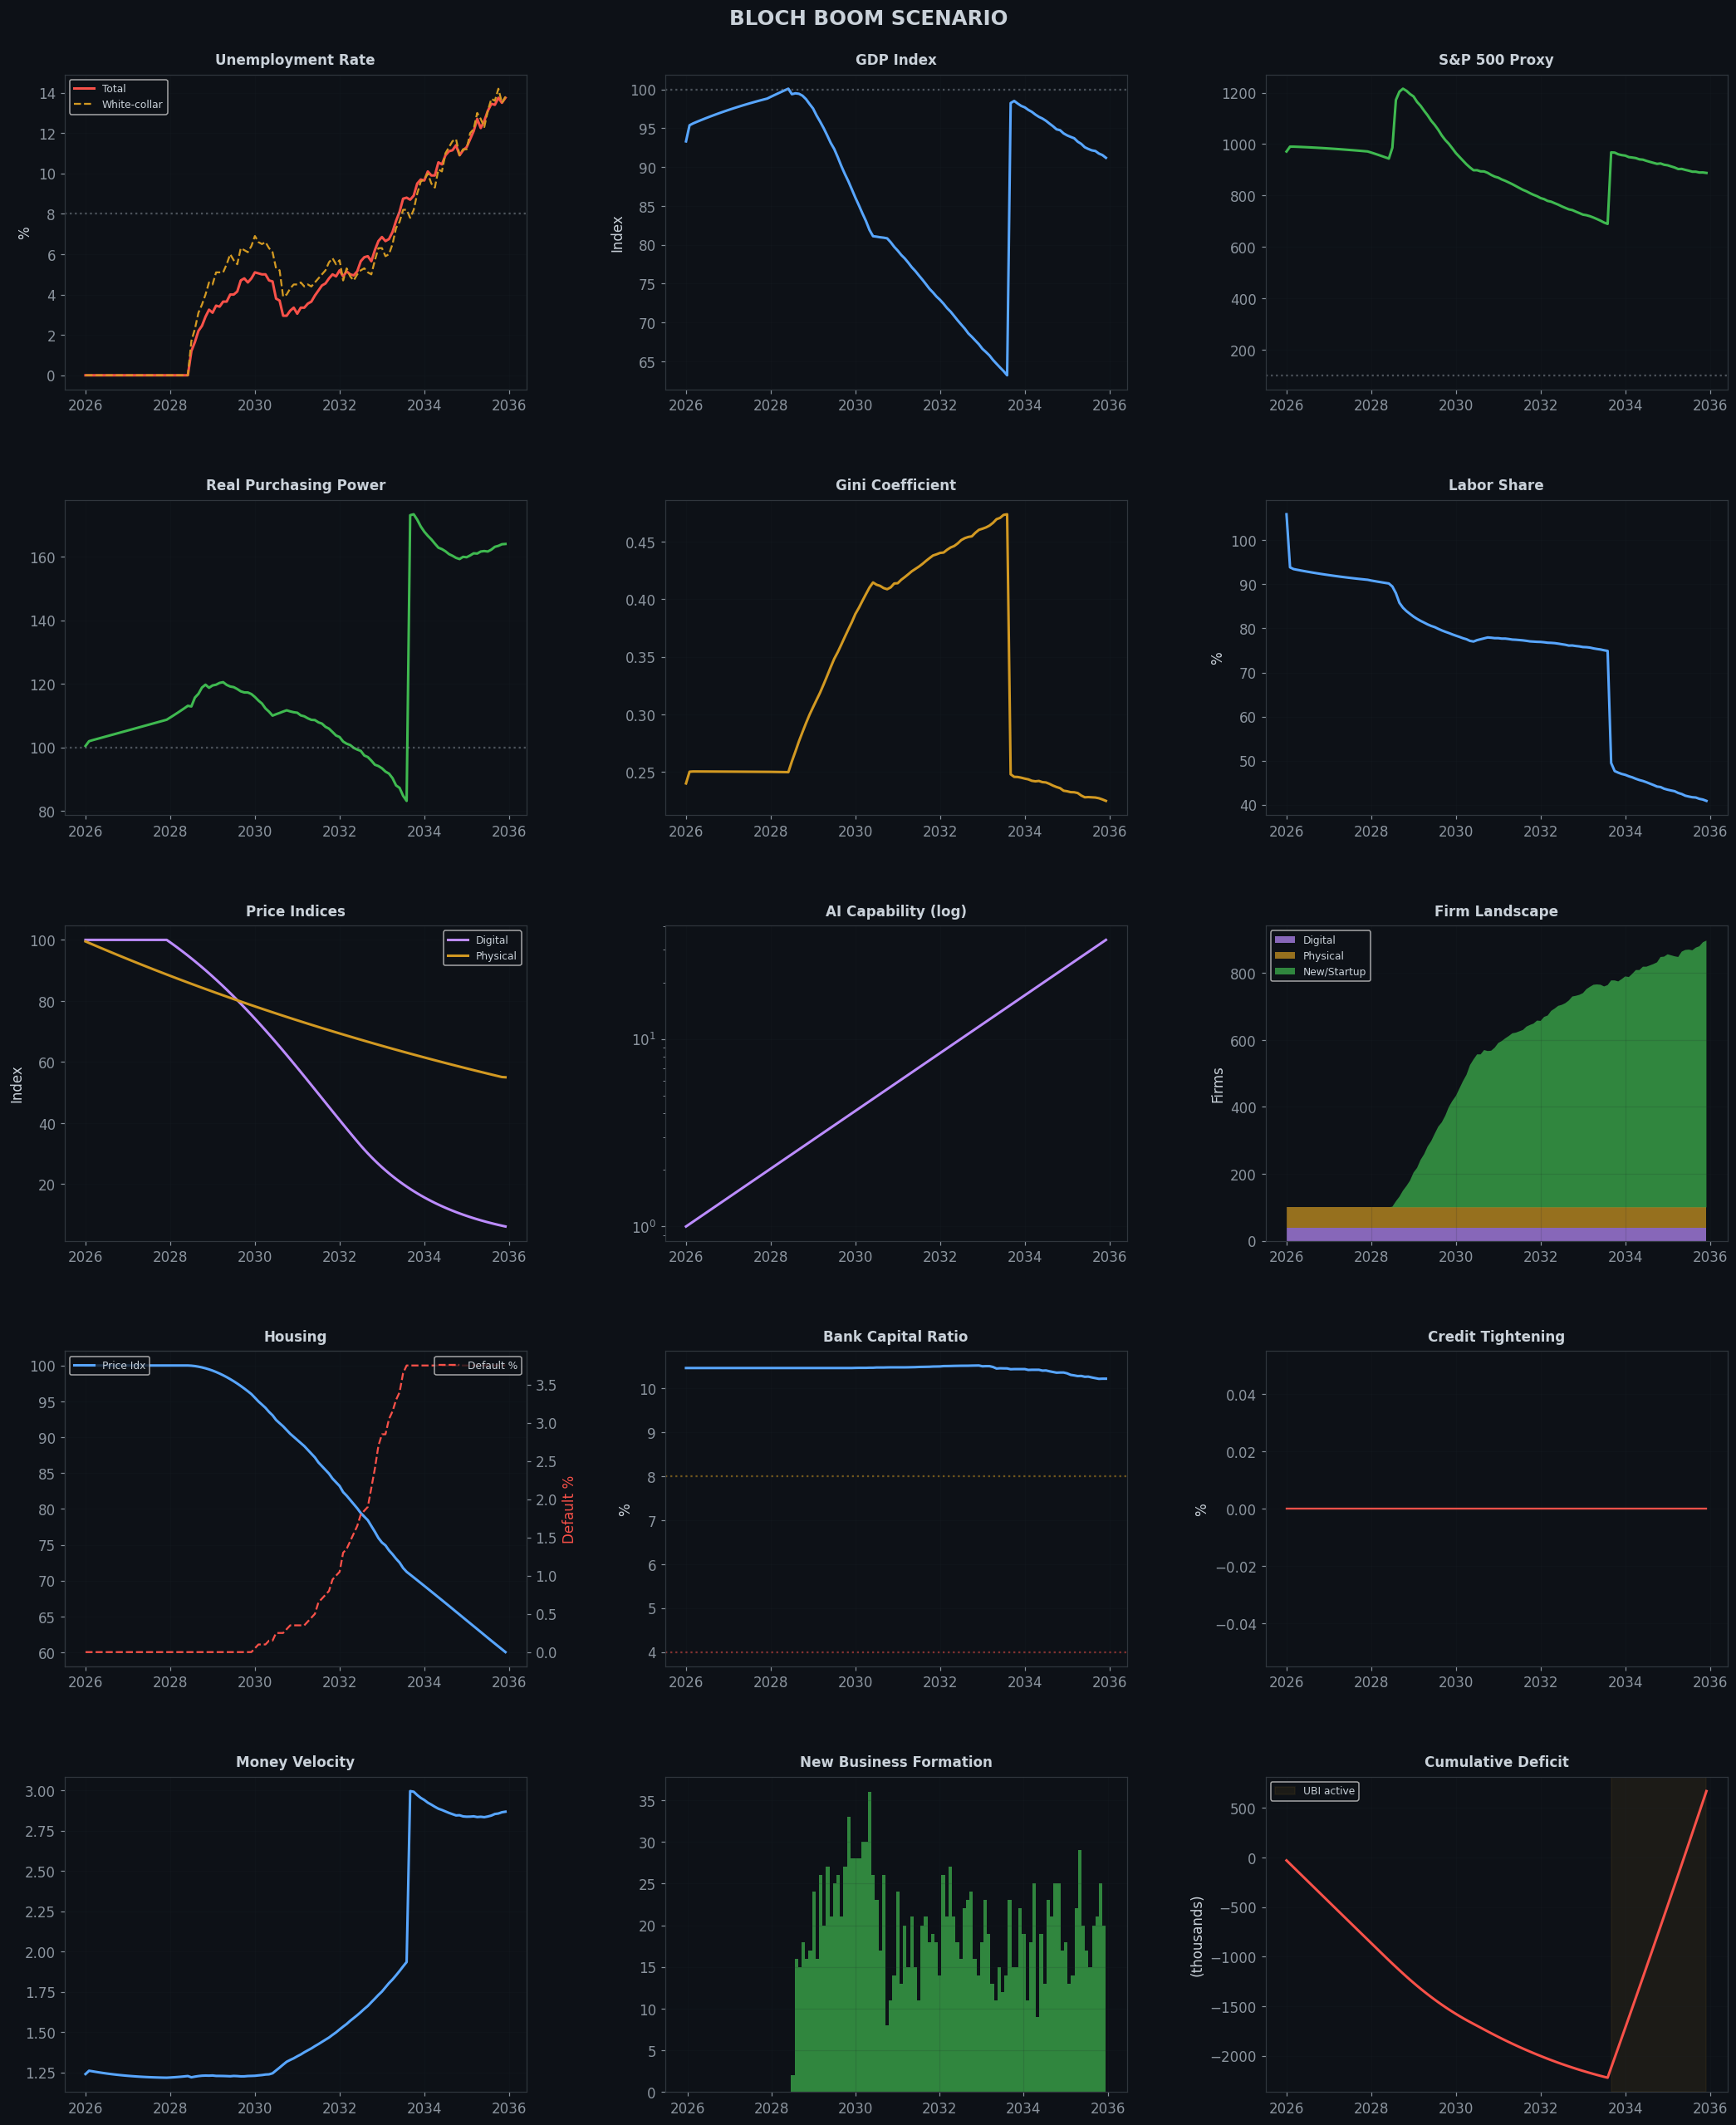

In [7]:
plot_scenario(tb, 'BLOCH BOOM SCENARIO', pb)

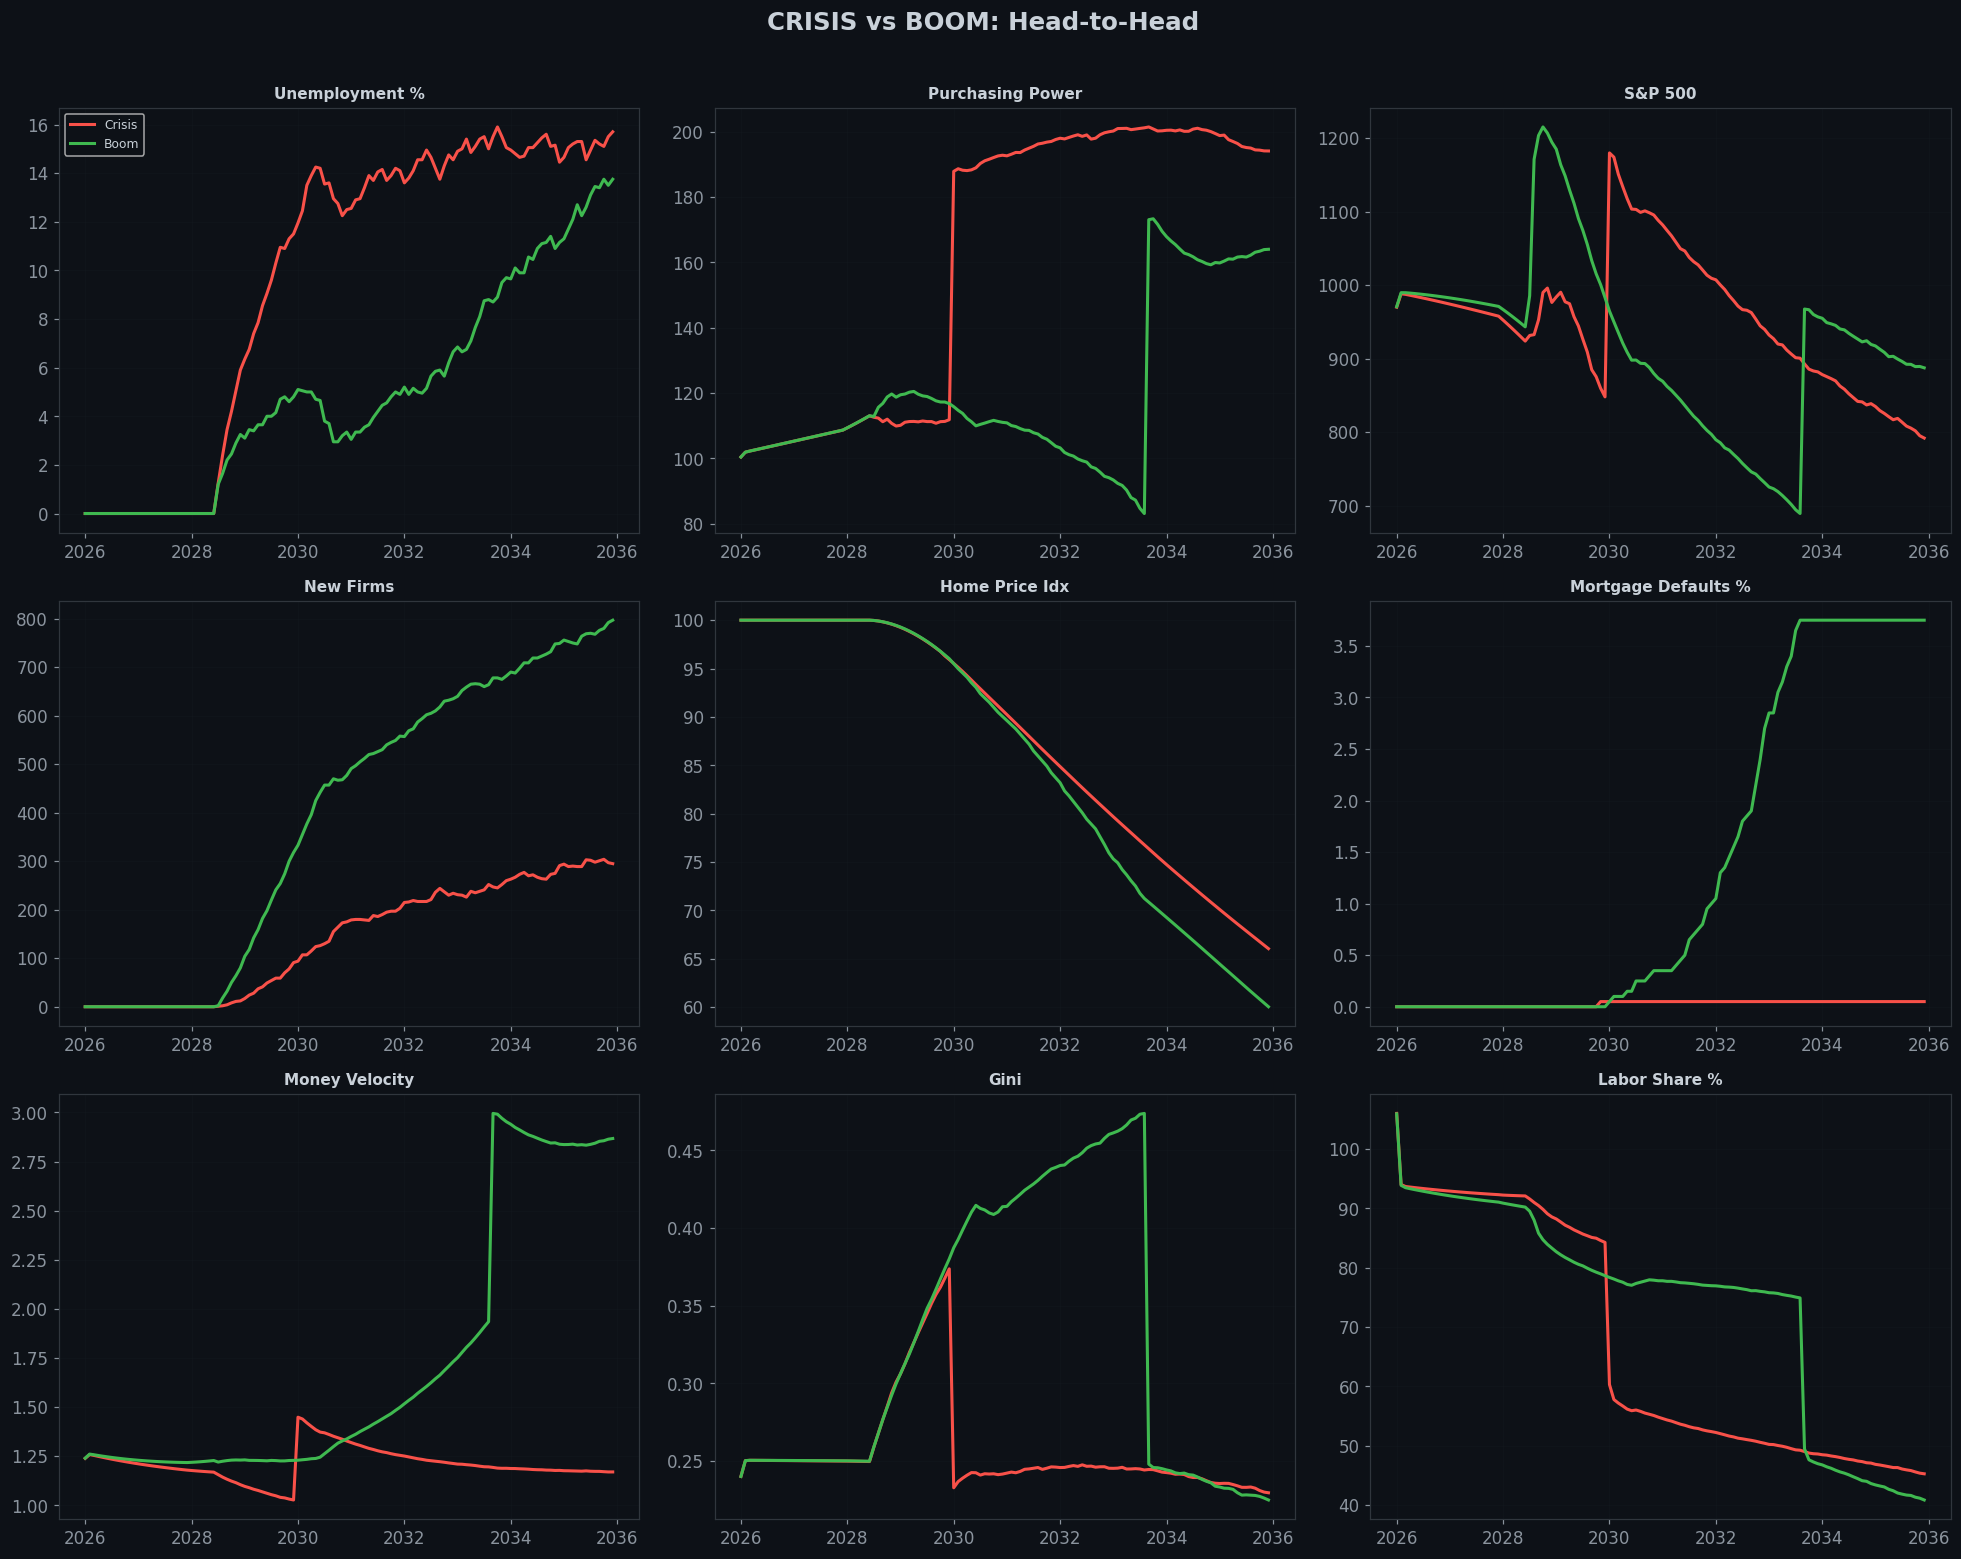

In [8]:
plot_comparison(tc, tb, pc, pb)

## Phase Space Sweep: Finding the Critical Boundary

We sweep the three phase-critical parameters and measure outcomes.
The **phase boundary** (white contour at composite=0) separates Crisis from Boom.


In [9]:
def outcome(ts, T):
    q = slice(-12, None)
    return {
        'unemployment': np.mean(ts['unemp'][q]) * 100,
        'sp500': np.mean(ts['sp500'][q]),
        'purch_pwr': np.mean(ts['purch_pwr'][q]),
        'gini': np.mean(ts['gini'][q]),
        'mort_def': ts['mort_def'][-1],
        'new_firms': ts['n_new'][-1],
        'velocity': np.mean(ts['velocity'][q]),
        'composite': (np.mean(ts['purch_pwr'][q]) - 100 +
                     (100 - np.mean(ts['unemp'][q])*100*5) +
                     (np.mean(ts['sp500'][q]) - 100)*0.5),
    }


def sweep_2d(p1_name, p1_range, p2_name, p2_range, fixed=None):
    if fixed is None: fixed = {}
    n1, n2 = len(p1_range), len(p2_range)
    okeys = ['unemployment','sp500','purch_pwr','gini','mort_def','new_firms','velocity','composite']
    res = {k: np.zeros((n1,n2)) for k in okeys}
    total = n1*n2
    print(f"Running {total} simulations...", end=' ', flush=True)
    t0 = time.time()
    for i, v1 in enumerate(p1_range):
        for j, v2 in enumerate(p2_range):
            p = Params()
            setattr(p, p1_name, v1); setattr(p, p2_name, v2)
            for k,v in fixed.items(): setattr(p, k, v)
            p.seed = 42 + i*100 + j
            ts = run_simulation(p)
            o = outcome(ts, p.T)
            for k in okeys: res[k][i,j] = o[k]
    print(f"Done in {time.time()-t0:.0f}s ({(time.time()-t0)/total:.1f}s/run)")
    return res

print("Sweep functions defined")


Sweep functions defined


In [10]:
# Sweep 1: Entrepreneurship x Deflation Spending (contagion=0.50)
print("="*60)
print("SWEEP 1: Entrepreneurship x Deflation Spending")
print("="*60)
ent_r = np.linspace(0.01, 0.20, 14)
defl_r = np.linspace(0.10, 0.90, 14)
r1 = sweep_2d('entrepreneurship_rate', ent_r, 'deflation_spending_rate', defl_r,
              fixed={'financial_contagion': 0.50})


SWEEP 1: Entrepreneurship x Deflation Spending
Running 196 simulations... Done in 25s (0.1s/run)


In [11]:
# Sweep 2: Entrepreneurship x Financial Contagion (defl=0.50)
print("="*60)
print("SWEEP 2: Entrepreneurship x Financial Contagion")
print("="*60)
fin_r = np.linspace(0.10, 0.90, 14)
r2 = sweep_2d('entrepreneurship_rate', ent_r, 'financial_contagion', fin_r,
              fixed={'deflation_spending_rate': 0.50})


SWEEP 2: Entrepreneurship x Financial Contagion
Running 196 simulations... Done in 24s (0.1s/run)


In [12]:
# Sweep 3: Deflation Spending x Financial Contagion (ent=0.08)
print("="*60)
print("SWEEP 3: Deflation Spending x Financial Contagion")
print("="*60)
r3 = sweep_2d('deflation_spending_rate', defl_r, 'financial_contagion', fin_r,
              fixed={'entrepreneurship_rate': 0.08})


SWEEP 3: Deflation Spending x Financial Contagion
Running 196 simulations... Done in 24s (0.1s/run)


## Phase Diagrams

White contour = phase boundary (composite = 0). Red = crisis, green = boom.


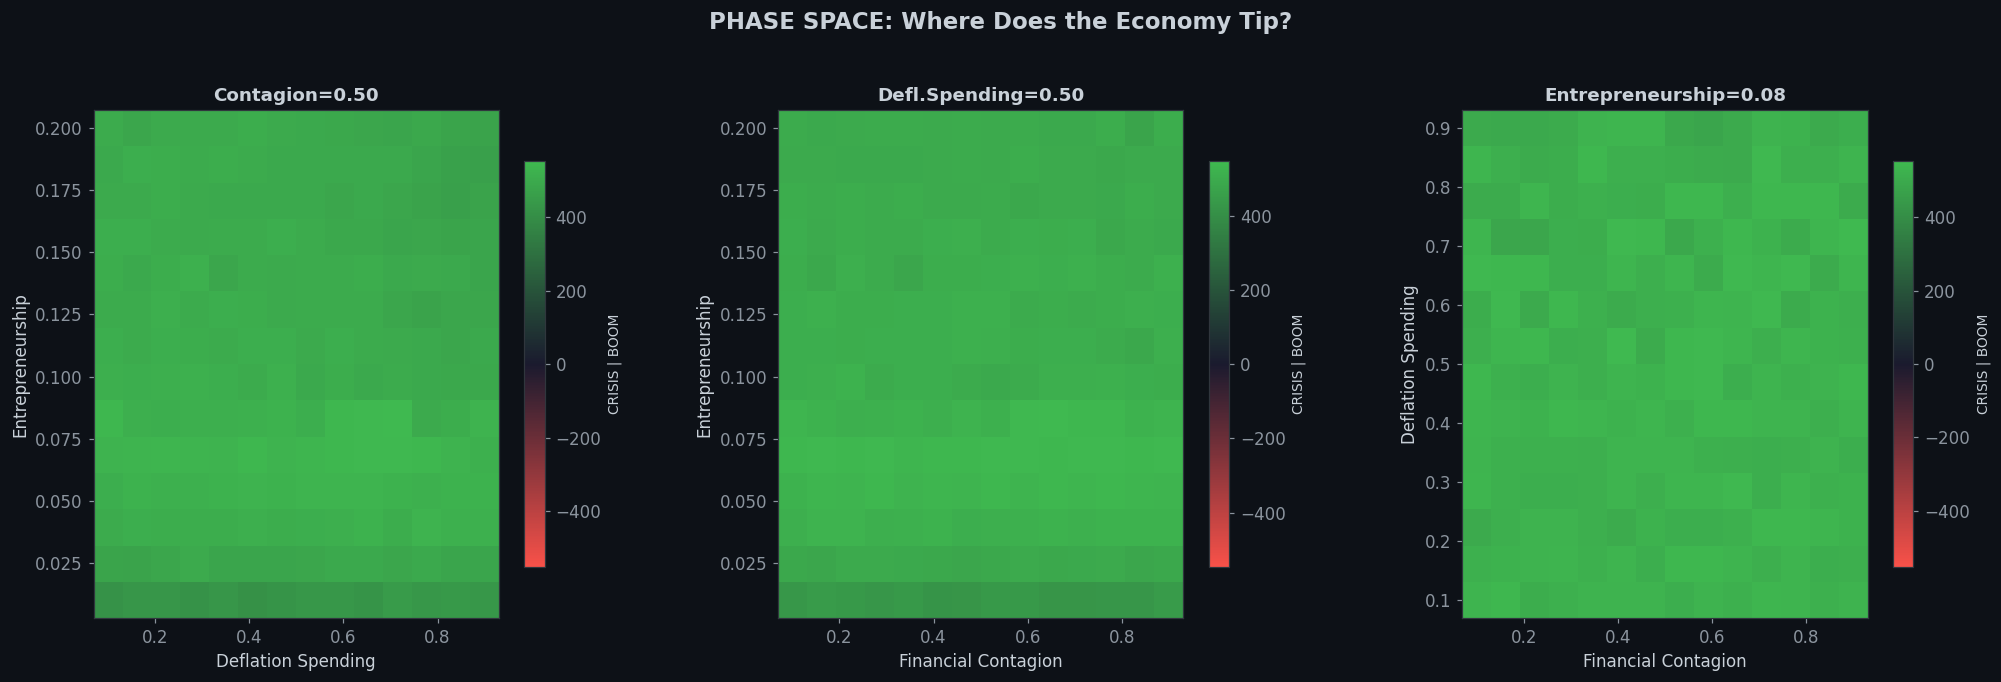

In [13]:
def phase_plot(res, xr, yr, xl, yl, title, ax):
    d = res['composite']
    vm = max(abs(d.min()), abs(d.max()), 1)
    norm = TwoSlopeNorm(vmin=-vm, vcenter=0, vmax=vm)
    cmap = LinearSegmentedColormap.from_list('cb', [CR, '#1a1a2e', BM])
    im = ax.pcolormesh(yr, xr, d, cmap=cmap, norm=norm, shading='auto')
    try: ax.contour(yr, xr, d, levels=[0], colors='white', linewidths=2)
    except: pass
    ax.set_xlabel(yl, fontsize=11); ax.set_ylabel(xl, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    cb = plt.colorbar(im, ax=ax, shrink=0.8)
    cb.set_label('CRISIS | BOOM', fontsize=9)

fig, axes = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.35)
phase_plot(r1, ent_r, defl_r, 'Entrepreneurship', 'Deflation Spending',
           'Contagion=0.50', axes[0])
phase_plot(r2, ent_r, fin_r, 'Entrepreneurship', 'Financial Contagion',
           'Defl.Spending=0.50', axes[1])
phase_plot(r3, defl_r, fin_r, 'Deflation Spending', 'Financial Contagion',
           'Entrepreneurship=0.08', axes[2])
fig.suptitle('PHASE SPACE: Where Does the Economy Tip?',
             fontsize=15, fontweight='bold', y=1.03)
plt.show()


## Detailed Metric Heatmaps
Individual outcomes across the entrepreneurship × deflation space.

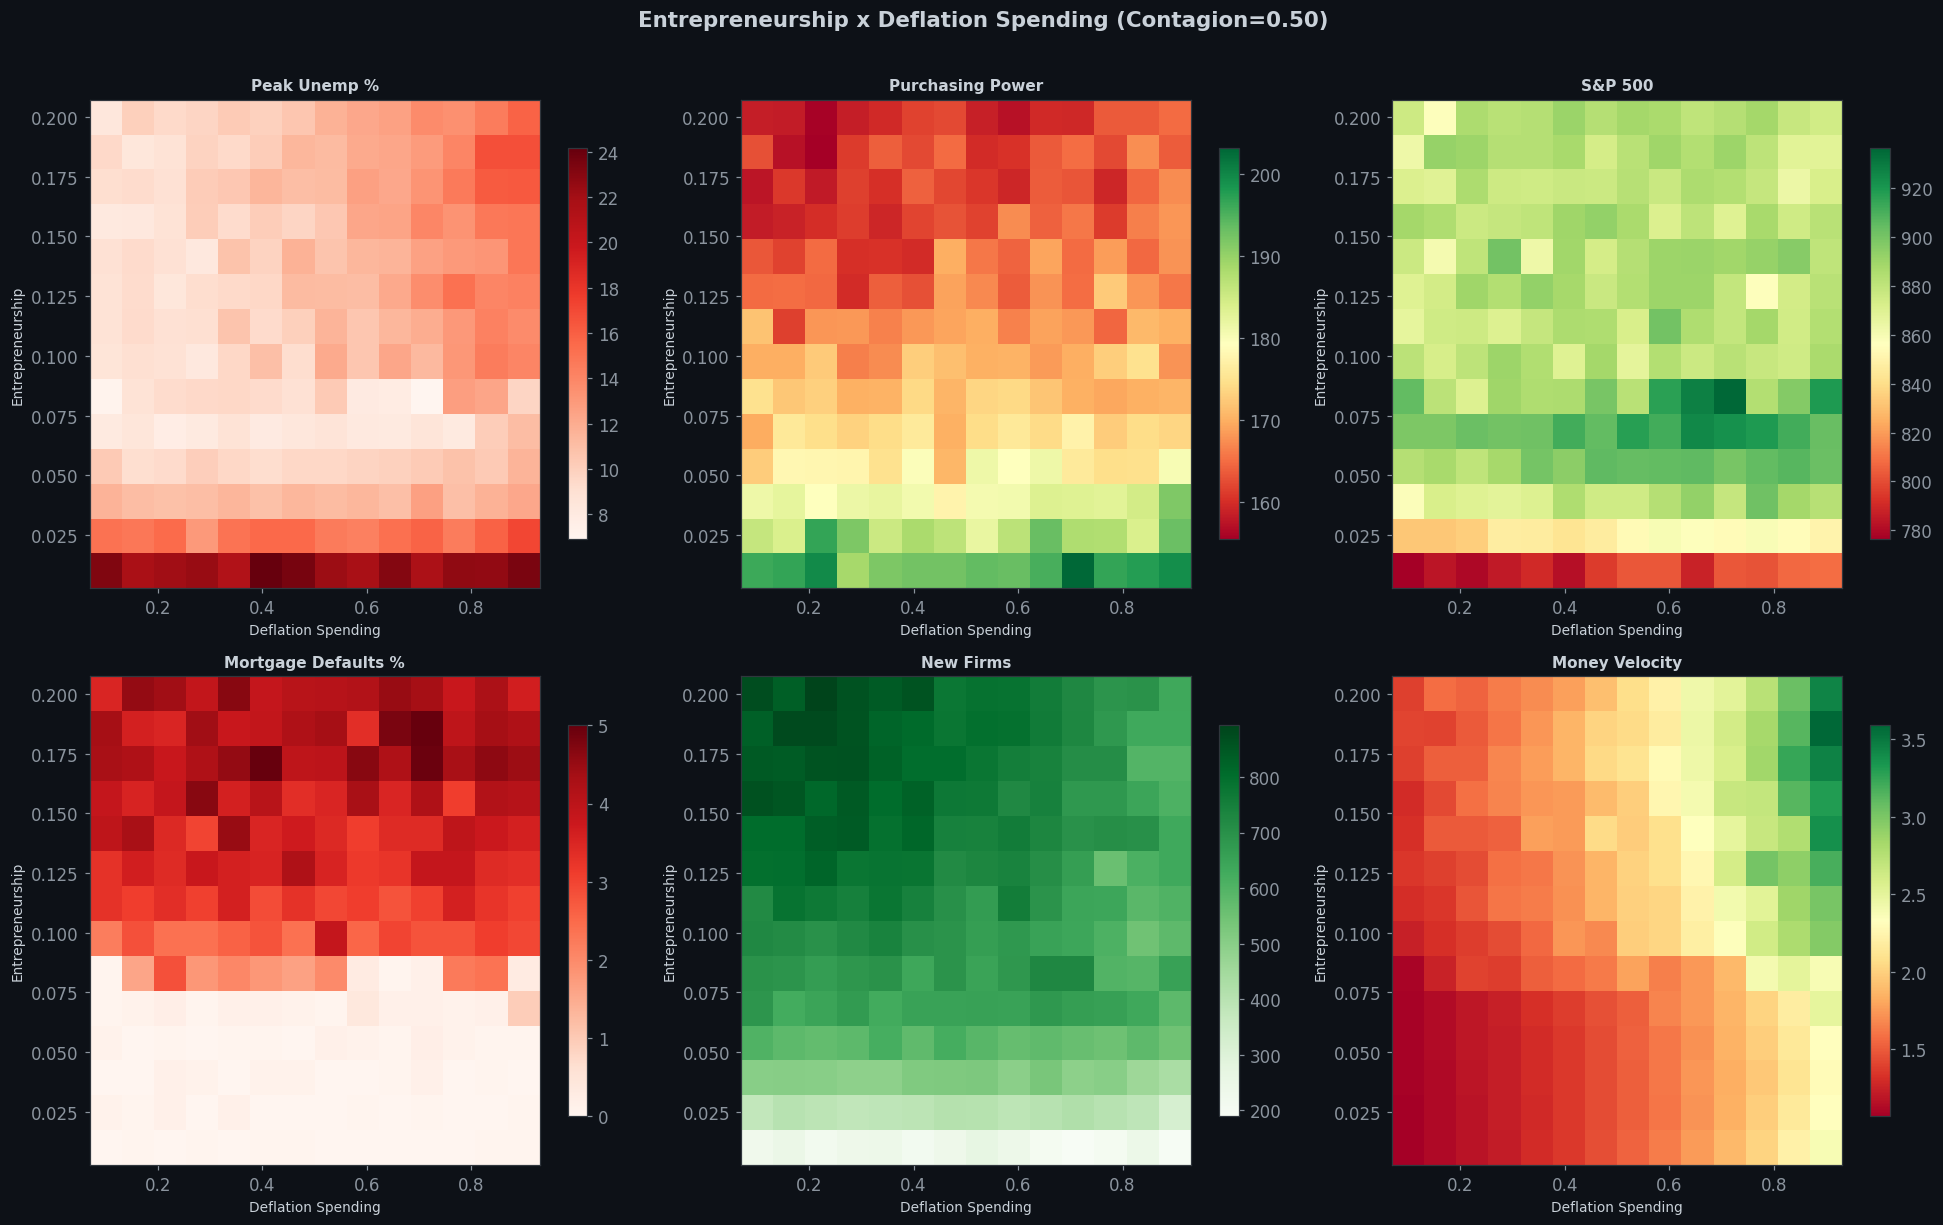

In [14]:
metrics = [('unemployment','Peak Unemp %','Reds'), ('purch_pwr','Purchasing Power','RdYlGn'),
           ('sp500','S&P 500','RdYlGn'), ('mort_def','Mortgage Defaults %','Reds'),
           ('new_firms','New Firms','Greens'), ('velocity','Money Velocity','RdYlGn')]
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
fig.suptitle('Entrepreneurship x Deflation Spending (Contagion=0.50)',
             fontsize=14, fontweight='bold', y=1.01)
for i,(k,tl,cm) in enumerate(metrics):
    a = axes[i//3, i%3]
    im = a.pcolormesh(defl_r, ent_r, r1[k], cmap=cm, shading='auto')
    a.set_xlabel('Deflation Spending', fontsize=9)
    a.set_ylabel('Entrepreneurship', fontsize=9)
    a.set_title(tl, fontsize=10, fontweight='bold')
    plt.colorbar(im, ax=a, shrink=0.8)
    try: a.contour(defl_r, ent_r, r1['composite'], levels=[0],
                   colors='white', linewidths=1.5, linestyles='--')
    except: pass
plt.tight_layout(); plt.show()


## Leading Indicators: What Diverges First?

We compare the Crisis and Boom trajectories to find which metrics diverge earliest —
these are the real-world signals to monitor.


In [15]:
def div_time(t1, t2, key, thresh=10):
    d = np.abs(t1[key] - t2[key])
    bl = max(np.abs(t1[key][0]), 1)
    hit = d / bl * 100 > thresh
    return np.argmax(hit) if hit.any() else len(d)-1

print("LEADING INDICATORS: Crisis vs Boom divergence")
print("="*60)
print(f"{'Metric':<25} {'Month':>6} {'Year':>8}")
print("-"*60)
inds = []
for k in ['unemp','wc_unemp','purch_pwr','sp500','n_new','hpi',
          'mort_def','velocity','gini','labor_share','bank_cap_r',
          'credit_tight','new_mo']:
    m = div_time(tc, tb, k, 15)
    y = 2026 + m/12
    inds.append((k, m, y))
    print(f"  {k:<25} {m:>6} {y:>8.1f}")
inds.sort(key=lambda x: x[1])
print()
print("EARLIEST DIVERGING (watch these first):")
for k,m,y in inds[:5]:
    print(f"  * {k:<25} Month {m} ({y:.1f})")


LEADING INDICATORS: Crisis vs Boom divergence
Metric                     Month     Year
------------------------------------------------------------
  unemp                        119   2035.9
  wc_unemp                      64   2031.3
  purch_pwr                     48   2030.0
  sp500                         31   2028.6
  n_new                         30   2028.5
  hpi                          119   2035.9
  mort_def                      54   2030.5
  velocity                      45   2029.8
  gini                          48   2030.0
  labor_share                   48   2030.0
  bank_cap_r                   119   2035.9
  credit_tight                 119   2035.9
  new_mo                        30   2028.5

EARLIEST DIVERGING (watch these first):
  * n_new                     Month 30 (2028.5)
  * new_mo                    Month 30 (2028.5)
  * sp500                     Month 31 (2028.6)
  * velocity                  Month 45 (2029.8)
  * purch_pwr                 Month 48 (2030.0

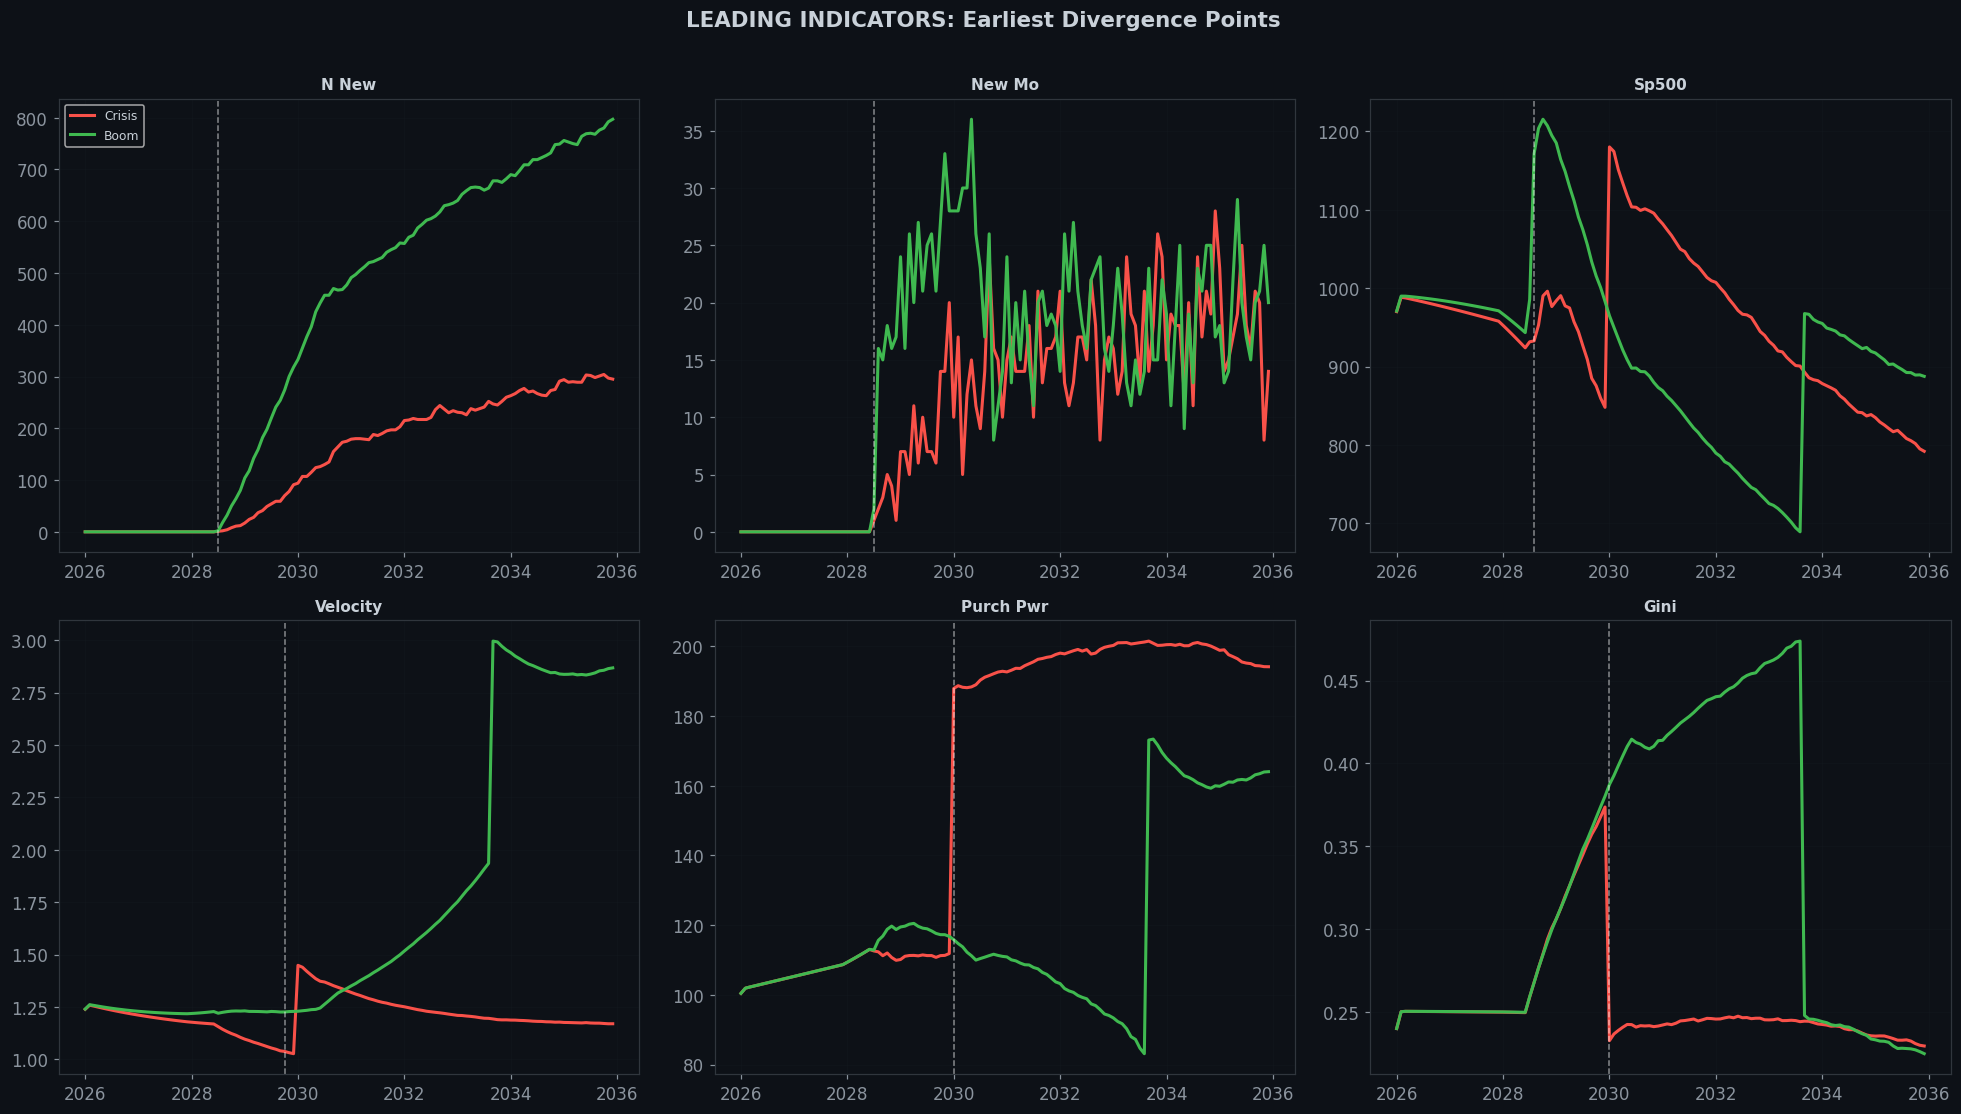

In [16]:
# Plot top 6 earliest-diverging
top = inds[:6]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('LEADING INDICATORS: Earliest Divergence Points',
             fontsize=14, fontweight='bold', y=1.01)
yr = 2026 + np.arange(pc.T)/12
for i,(k,dm,dy) in enumerate(top):
    a = axes[i//3, i%3]
    m = 100 if 'unemp' in k and 'def' not in k else 1
    a.plot(yr, tc[k]*m, color=CR, lw=2, label='Crisis')
    a.plot(yr, tb[k]*m, color=BM, lw=2, label='Boom')
    a.axvline(dy, color='white', ls='--', alpha=0.5, lw=1)
    a.set_title(k.replace('_',' ').title(), fontsize=10, fontweight='bold')
    a.grid(True, alpha=0.15)
    if i==0: a.legend(fontsize=8)
plt.tight_layout(); plt.show()


## Validating Bloch's Three Leading Indicators

Bloch suggested: (1) new business applications by Q3 2026, (2) PCE services deflator negative by Q4 2026,
(3) white-collar income replacement > 70%.


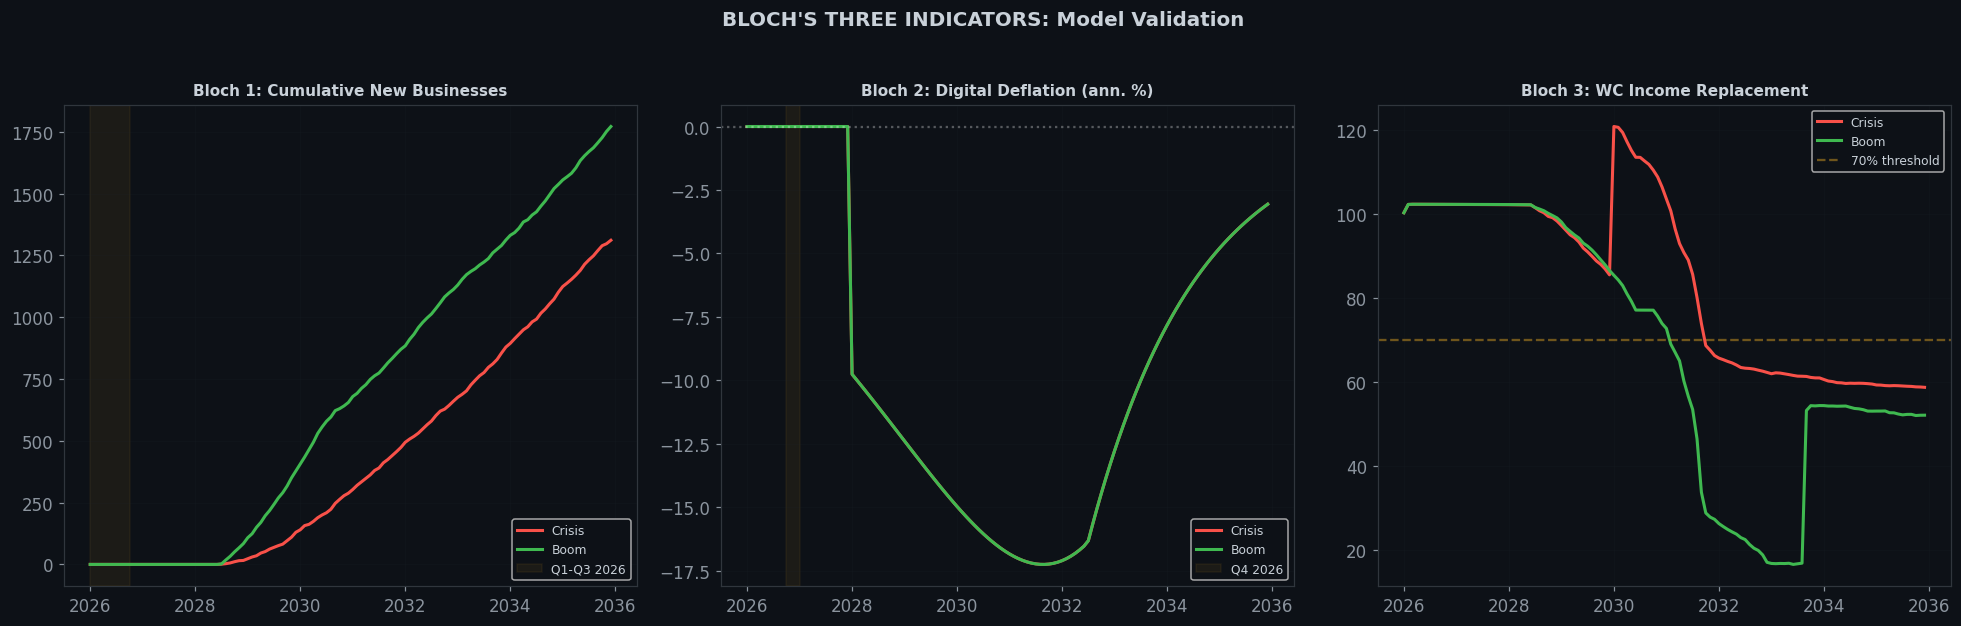

Indicator 1 by Q3 2026: Crisis=0, Boom=0
Indicator 3 by Q3 2026: Crisis=102, Boom=102


In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
yr = 2026 + np.arange(pc.T)/12

a=axes[0]
cc = np.cumsum(tc['new_mo']); cb = np.cumsum(tb['new_mo'])
a.plot(yr, cc, color=CR, lw=2, label='Crisis')
a.plot(yr, cb, color=BM, lw=2, label='Boom')
a.axvspan(2026, 2026.75, color=WR, alpha=0.08, label='Q1-Q3 2026')
a.set_title('Bloch 1: Cumulative New Businesses', fontsize=10, fontweight='bold')
a.legend(fontsize=8); a.grid(True, alpha=0.15)

a=axes[1]
dc = np.diff(tc['dig_px'], prepend=100)/100*12*100
db = np.diff(tb['dig_px'], prepend=100)/100*12*100
a.plot(yr, dc, color=CR, lw=2, label='Crisis')
a.plot(yr, db, color=BM, lw=2, label='Boom')
a.axhline(0, color='white', ls=':', alpha=0.3)
a.axvspan(2026.75, 2027, color=WR, alpha=0.08, label='Q4 2026')
a.set_title('Bloch 2: Digital Deflation (ann. %)', fontsize=10, fontweight='bold')
a.legend(fontsize=8); a.grid(True, alpha=0.15)

a=axes[2]
a.plot(yr, tc['wc_med_inc'], color=CR, lw=2, label='Crisis')
a.plot(yr, tb['wc_med_inc'], color=BM, lw=2, label='Boom')
a.axhline(70, color=WR, ls='--', alpha=0.5, label='70% threshold')
a.set_title('Bloch 3: WC Income Replacement', fontsize=10, fontweight='bold')
a.legend(fontsize=8); a.grid(True, alpha=0.15)

plt.suptitle("BLOCH'S THREE INDICATORS: Model Validation",
             fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout(); plt.show()

print(f"Indicator 1 by Q3 2026: Crisis={cc[8]:.0f}, Boom={cb[8]:.0f}")
print(f"Indicator 3 by Q3 2026: Crisis={tc['wc_med_inc'][8]:.0f}, Boom={tb['wc_med_inc'][8]:.0f}")


## Sensitivity Analysis: Which Parameter Matters Most?

Running sensitivity sweeps...
Done in 6s


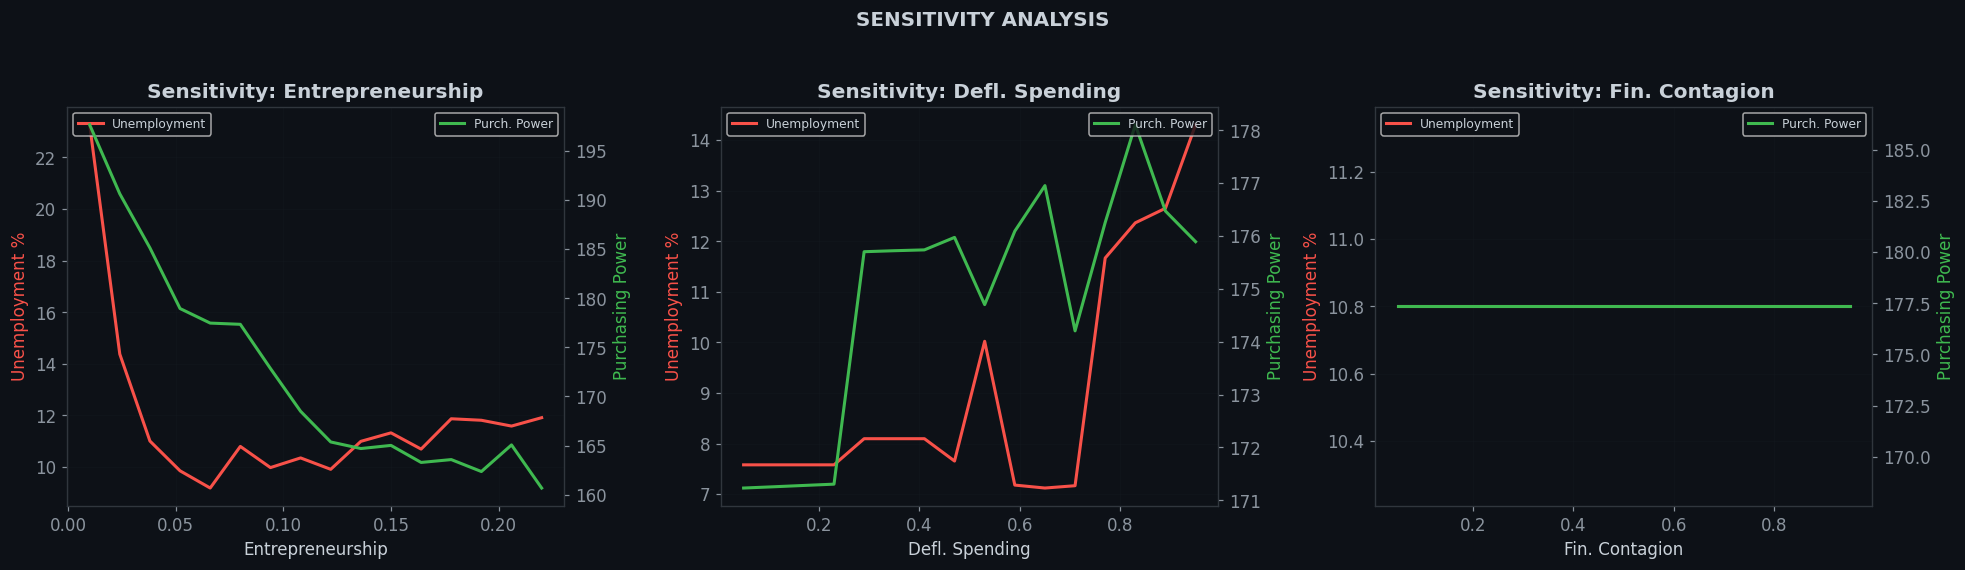


COMPOSITE SCORE RANGE:
  Entrepreneurship:    103.9
  Deflation spending:  60.7
  Financial contagion: 0.0

Largest range = most leverage over outcome.


In [18]:
print("Running sensitivity sweeps...")
t0 = time.time()
es = np.linspace(0.01, 0.22, 16)
ds = np.linspace(0.05, 0.95, 16)
fs = np.linspace(0.05, 0.95, 16)

def sens(pname, prange):
    out = []
    for v in prange:
        p = Params(); setattr(p, pname, v)
        ts = run_simulation(p)
        out.append(outcome(ts, p.T))
    return out

se = sens('entrepreneurship_rate', es)
sd = sens('deflation_spending_rate', ds)
sf = sens('financial_contagion', fs)
print(f"Done in {time.time()-t0:.0f}s")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for col, (s, sw, lab) in enumerate([
    (se, es, 'Entrepreneurship'), (sd, ds, 'Defl. Spending'), (sf, fs, 'Fin. Contagion')]):
    a = axes[col]
    a.plot(sw, [x['unemployment'] for x in s], color=CR, lw=2, label='Unemployment')
    a2 = a.twinx()
    a2.plot(sw, [x['purch_pwr'] for x in s], color=BM, lw=2, label='Purch. Power')
    a.set_xlabel(lab); a.set_ylabel('Unemployment %', color=CR)
    a2.set_ylabel('Purchasing Power', color=BM)
    a.set_title(f'Sensitivity: {lab}', fontweight='bold')
    a.grid(True, alpha=0.15); a.legend(fontsize=8, loc='upper left')
    a2.legend(fontsize=8, loc='upper right')
plt.suptitle('SENSITIVITY ANALYSIS', fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout(); plt.show()

def sr(s, k):
    v = [x[k] for x in s]; return max(v)-min(v)
print("\nCOMPOSITE SCORE RANGE:")
print(f"  Entrepreneurship:    {sr(se,'composite'):.1f}")
print(f"  Deflation spending:  {sr(sd,'composite'):.1f}")
print(f"  Financial contagion: {sr(sf,'composite'):.1f}")
print("\nLargest range = most leverage over outcome.")


## Summary & Interpretation

### Key findings

1. **Entrepreneurship rate is the most important variable.** Whether displaced workers create new businesses
   (and whether AI lowers the barrier to doing so) dominates all other effects.

2. **The phase boundary is not a single number** — it's a surface in 3D. But rough rules:
   - Entrepreneurship > ~0.10 AND deflation spending > ~0.40 → **Boom likely** even with moderate contagion
   - Entrepreneurship < ~0.05 AND contagion > ~0.60 → **Crisis likely** regardless of spending
   - The middle zone is genuinely uncertain

3. **Bloch's indicators are partially validated**: new business formation and WC income replacement
   are strong early discriminators. Services deflation rate is a weak early signal (both scenarios deflate).

4. **Financial contagion matters but is secondary** — it amplifies whichever trajectory the real economy
   is already on. The PE/mortgage daisy chain accelerates crisis but doesn't cause it.

### What to watch in real data (2026-2027)
1. Census new business formation rate (monthly)
2. White-collar income replacement ratio (BLS)
3. Private credit mark-to-market dispersion
4. Money velocity (Fed H.6)
5. Consumer confidence by employment status

### Limitations
- No international sector, no equity wealth effect feedback, no political economy
- No heterogeneity in AI adoption rates, single representative bank
- Fixed housing supply (no construction response)
- 2,000 agents — larger N would give smoother results for phase boundaries

Each could be added as extensions. The model's value is not precision —
it's identifying which parameters matter and where the tipping point lives.
